In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_label(x):
    if x==0:
        return 'Left'
    elif x==1:
        return 'Right'
    elif x==2:
        return 'Up'
    elif x==3:
        return 'Down'

In [3]:
class DynaMaze:
    
    def __init__(self, grid_size, n, terminal_state, blocked_blocks, mode_type = 'DQ', verbose=False):
        
        self.grid_size = grid_size
        self.n = n
        self.terminal_state = terminal_state
        self.blocked_blocks = blocked_blocks
        self.mode_type = mode_type
        self.verbose = verbose
        self.gamma = 0.1
        
        self.Q = np.zeros((self.grid_size, self.grid_size, 4)) + 0.25
        
        self.actions = [(0,-1), (0, 1), (-1,0), (1, 0)]# Left, Right, Up, Down

        #Equi-probable action selection at each state for all actions
        self.policy = np.random.randint(1,4,size = (self.grid_size, self.grid_size))
                
        if self.verbose:
            print("Shape of Q", self.Q.shape)
            print("Shape of Policy", self.policy.shape)
            print("Initial State-Action/Q Function", *self.Q, sep='\n',end='\n\n')
            print("Initial Policy", *self.policy, sep='\n',end='\n\n')
        
    def _get_reward(self, x, y, a):
        
        # Reward of 30, -2, -1 on reaching the terminal state, 
        # blocked blocks and other blocks respectively.
        
        if x+a[0]==self.terminal_state[0] and y+a[1]==self.terminal_state[1]:
            return 30
        if (x+a[0]==-1 or x+a[0]==self.grid_size) or (y+a[1]==-1 or y+a[1]==self.grid_size):
            return -3
        if (x+a[0],y+a[1]) in self.blocked_blocks:
            return -3
        return -1

    def _get_time_dependent_reward(self, x, y, a, t):
        
        # Reward of 30, -2, -1 on reaching the terminal state, 
        # blocked blocks and other maze blocks respectively.
        
        if x+a[0]==self.terminal_state[0] and y+a[1]==self.terminal_state[1]:
            return 30
        if (x+a[0]==-1 or x+a[0]==self.grid_size) or (y+a[1]==-1 or y+a[1]==self.grid_size):
            return -3
        if (x+a[0],y+a[1]) in self.blocked_blocks:
            return -3
        return (-1 + 0.00000000001*np.sqrt(t))
    
    def _get_next_state(self, x, y, a):
        
        if (x+a[0], y+a[1]) in self.blocked_blocks:
            return x,y
        if x+a[0]!=-1 and x+a[0]!=self.grid_size:
            x = x + a[0]
        if y+a[1]!=-1 and y+a[1]!=self.grid_size:
            y = y + a[1]
        return x,y
        
    def play(self, epochs = 100, threshold = 1e-8, changed=True):
        
        if self.mode_type == 'DQ':
            res = self._play_dq(epochs, threshold, changed)
            
            fig, ax = plt.subplots(figsize=(self.grid_size*2, self.grid_size*2))
            anotations = np.array(list(map(get_label, self.policy.reshape(-1,1)))).reshape(self.policy.shape)
            anotations[self.terminal_state[0], self.terminal_state[1]] = 'Terminal'
            for i,j in self.blocked_blocks:
                anotations[i,j] = 'Blocked'
            sns.heatmap(self.policy, annot=anotations, fmt='', cmap='Blues', ax = ax)
            plt.show()
            
            if self.verbose:
                print("Final Policy:")
                print(*self.policy, sep = '\n', end = '\n\n')
                print("Final State-Action/Q Function:")
                print(*self.Q, sep = '\n', end = '\n\n')
                
            return res
        
        elif self.mode_type == 'DQ+':
            res = self._play_dq_plus(epochs, threshold, changed)
            
            fig, ax = plt.subplots(figsize=(self.grid_size*2, self.grid_size*2))
            anotations = np.array(list(map(get_label, self.policy.reshape(-1,1)))).reshape(self.policy.shape)
            anotations[self.terminal_state[0], self.terminal_state[1]] = 'Terminal'
            for i,j in self.blocked_blocks:
                anotations[i,j] = 'Blocked'
            sns.heatmap(self.policy, annot=anotations, fmt='', cmap='Blues', ax = ax)
            plt.show()
            
            if self.verbose:
                print("Final Policy:")
                print(*self.policy, sep = '\n', end = '\n\n')
                print("Final State-Action/Q Function:")
                print(*self.Q, sep = '\n', end = '\n\n')
            return res
        
        elif self.mode_type == 'PS':
            res = self._play_priority_sweep(epochs, threshold)
            
            fig, ax = plt.subplots(figsize=(self.grid_size*2, self.grid_size*2))
            anotations = np.array(list(map(get_label, self.policy.reshape(-1,1)))).reshape(self.policy.shape)
            anotations[self.terminal_state[0], self.terminal_state[1]] = 'Terminal'
            sns.heatmap(self.policy, annot=anotations, fmt='', cmap='Blues', ax = ax)
            plt.show()
            
            if self.verbose:
                print("Final Policy:")
                print(*self.policy, sep = '\n', end = '\n\n')
                print("Final State-Action/Q Function:")
                print(*self.Q, sep = '\n', end = '\n\n')     
            return res
        
    def _get_action(self, x,y):

        m = np.round(np.min(self.Q[x][y])-1, 3)
        probs = (np.round(self.Q[x][y], 5)-m) / np.sum(np.round(self.Q[x][y], 5) - m)
        try:
            
            return np.random.choice([0,1,2,3],p=probs)
        except:
            print(m,probs)
    
    def _play_dq(self, epochs, threshold, changed=True):
        
        iters = 0
        avg_length = []
        all_rewards = []
        model = {}
        states = set()
        
        while True:
            
            iters+=1
            x=0
            y=self.grid_size//2
            diff = 0
            old_Q = np.array(self.Q)
            length = 0
            rewards = []
            
            #After 300 iterations change the block
            if (iters == 400 or diff < threshold) and changed:
                temp = list(self.blocked_blocks)
                temp.pop()
                self.blocked_blocks = tuple(temp)
                changed = False
            
            while True:
                
                    length+=1
                    action = self._get_action(x,y)
                    new_x, new_y = self._get_next_state(x,y,self.actions[action])
                    reward = self._get_reward(x,y,self.actions[action])
                    rewards.append(reward)
                    
                    states = states.union({(x,y,action)})
                    model[(x,y,action)] = (new_x, new_y, reward)
                    
                    if self.verbose:
                        print("X, Y, Action, Rewards:", [x,y,action,rewards])                       
                       
                    self.Q[x,y,action] = self.Q[x,y,action] + 0.1*(reward + self.gamma*np.max(self.Q[new_x, new_y]) - self.Q[x, y, action])
                    self.policy[x,y] = np.argmax(self.Q[x][y])
                    
                    if self.verbose:
                        print("N=", self.n, "Length:", len(states))
                    
                    for i in range(self.n):
                        temp_x, temp_y, temp_action = list(states)[np.random.randint(len(states))]
                        temp_new_x, temp_new_y, temp_reward = model[(temp_x, temp_y, temp_action)]
                        self.Q[temp_x, temp_y, temp_action] = self.Q[temp_x, temp_y, temp_action] + 0.1*(temp_reward + self.gamma*np.max(self.Q[temp_new_x, temp_new_y]) - self.Q[temp_x, temp_y, temp_action])
                        self.policy[temp_x, temp_y] = np.argmax(self.Q[temp_x, temp_y])
                    
                    x, y = new_x, new_y
                    
                    if reward>0:
                        break

            avg_length.append(length)
            diff = np.mean(np.square(old_Q-self.Q))
            all_rewards.append(np.sum(rewards))
            
            if self.verbose:
                print('IDs & Difference(MSE):', id(old_Q), id(self.Q), diff)
                
                        
            if self.verbose:
                print("Q function at iter:", iters)
                print(*self.Q, sep = '\n', end = '\n\n')
            
            if self.verbose:
                print("Policy at iter:", iters)
                print(*self.policy, sep = '\n', end = '\n\n')
            
            if epochs==iters or diff < threshold:
                return diff, iters, np.mean(avg_length), all_rewards
            
    def _play_dq_plus(self, epochs, threshold, changed = True):
        
        iters = 0
        avg_length = []
        all_rewards = []
        model = {}
        states = set()
        occurence = np.zeros((self.grid_size, self.grid_size, 4))
        
        while True:
            
            iters+=1
            x=0
            y=self.grid_size//2
            diff = 0
            old_Q = np.array(self.Q)
            length = 0
            rewards = []
            
            #After 300 iterations change the block
            if (iters == 300 or diff < threshold) and changed:
                temp = list(self.blocked_blocks)
                temp.pop()
                self.blocked_blocks = tuple(temp)
                changed = False
            
            occurence = occurence + 1
            
            while True:
                
                    length+=1
                    action = self._get_action(x,y)
                    new_x, new_y = self._get_next_state(x,y,self.actions[action])
                    reward = self._get_time_dependent_reward(x,y,self.actions[action], occurence[x,y,action])
                    rewards.append(reward)
                    
                    if self.verbose:
                        print("Occurenece Matrix:", *occurence, sep='\n',end='\n\n')
                    
                    states = states.union({(x,y,action)})
                    model[(x,y,action)] = (new_x, new_y, reward)
                    
                    if self.verbose:
                        print("X, Y, Action, Rewards:", [x,y,action,rewards])                       
                       
                    self.Q[x,y,action] = self.Q[x,y,action] + 0.1*(reward + self.gamma*np.max(self.Q[new_x, new_y]) - self.Q[x,y,action])
                    self.policy[x,y] = np.argmax(self.Q[x][y])
                    
                    occurence[x,y,action] = 0
                    
                    if self.verbose:
                        print("N=", self.n, "Length:", len(states))
                    
                    for i in range(self.n):
                        temp_x, temp_y, temp_action = list(states)[np.random.randint(len(states))]
                        temp_new_x, temp_new_y, temp_reward = model[(temp_x, temp_y, temp_action)]
                        self.Q[temp_x, temp_y, temp_action] = self.Q[temp_x, temp_y, temp_action] + 0.1*(temp_reward + self.gamma*np.max(self.Q[temp_new_x, temp_new_y]) - self.Q[temp_x, temp_y, temp_action])
                        self.policy[temp_x, temp_y] = np.argmax(self.Q[temp_x, temp_y])
                        
                    x, y = new_x, new_y
                    
                    if x==self.terminal_state[0] and y==self.terminal_state[1]:
                        break

            avg_length.append(length)
            diff = np.mean(np.square(old_Q-self.Q))
            all_rewards.append(np.mean(rewards))
            
            if self.verbose:
                print('IDs & Difference(MSE):', id(old_Q), id(self.Q), diff)
                
                        
            if self.verbose:
                print("Q function at iter:", iters)
                print(*self.Q, sep = '\n', end = '\n\n')
            
            if self.verbose:
                print("Policy at iter:", iters)
                print(*self.policy, sep = '\n', end = '\n\n')
            
            if epochs==iters or diff < threshold:
                return diff, iters, np.mean(avg_length), all_rewards
            
    def _play_priority_sweep(self, epochs, threshold):
        
        iters = 0
        avg_length = []
        rewards = []
        model = {}
        states = []
        occurence = np.zeros((self.grid_size, self.grid_size, 4))
        
        while True:
            
            iters+=1
            x=0
            y=0
            diff = 0
            old_Q = np.array(self.Q)
            length = 0
            
            if iters == 200:
                self.blocked_blocks
            
            while True:
                
                    length+=1
                    action = self._get_action(x,y)
                    new_x, new_y = self._get_next_state(x,y,self.actions[action])
                    reward = self._get_time_dependent_reward(x,y,self.actions[action], occurence[x,y,action])
                    rewards.append(reward)
                    
                    if self.verbose:
                        print("Occurenece Matrix:", *occurence, sep='\n',end='\n\n')
                    
                    states = states.union({(x,y)})
                    model[(x,y,action)] = (new_x, new_y, reward)
                    
                    if self.verbose:
                        print("X, Y, Action, Rewards:", [x,y,action,rewards])                       
                       
                    self.Q[x,y,action] = self.Q[x,y,action] + 0.1*(reward + self.gamma*np.max(self.Q[new_x, new_y]) - self.Q[temp_x, temp_y, temp_action])
                    self.policy[x,y] = np.argmax(self.Q[x][y])
                    
                    occurence = occurence + 1
                    occurence[x,y,action] = 1
                    
                    if self.verbose:
                        print("N=", self.n, "Length:", len(states))
                    
                    for i in range(self.n):
                        temp_x, temp_y = list(states)[np.random,randint(len(states))]
                        temp_action = self._get_action(temp_x, temp_y)
                        temp_new_x, temp_new_y, temp_reward = model[(temp_x, temp_y, temp_action)]
                        self.Q[temp_x, temp_y, temp_action] = self.Q[temp_x, temp_y, temp_action] + 0.1*(reward + self.gamma*np.max(self.Q[temp_new_x, temp_new_y]) - self.Q[temp_x, temp_y, temp_action])
                        self.policy[temp_x, temp_y] = np.argmax(self.Q[temp_x, temp_y])
                        
                    x, y = new_x, new_y
                    
                    if x==self.terminal_state[0] and y==self.terminal_state[1]:
                        break

            avg_length.append(length)
            diff = np.mean(np.square(old_Q-self.Q))
            
            if self.verbose:
                print('IDs & Difference(MSE):', id(old_Q), id(self.Q), diff)
                
                        
            if self.verbose:
                print("Q function at iter:", iters)
                print(*self.Q, sep = '\n', end = '\n\n')
            
            if self.verbose:
                print("Policy at iter:", iters)
                print(*self.policy, sep = '\n', end = '\n\n')
            
            if epochs==iters or diff < threshold:
                return diff, iters, np.mean(avg_length), rewards

# DQ Learning

Planning size: 0


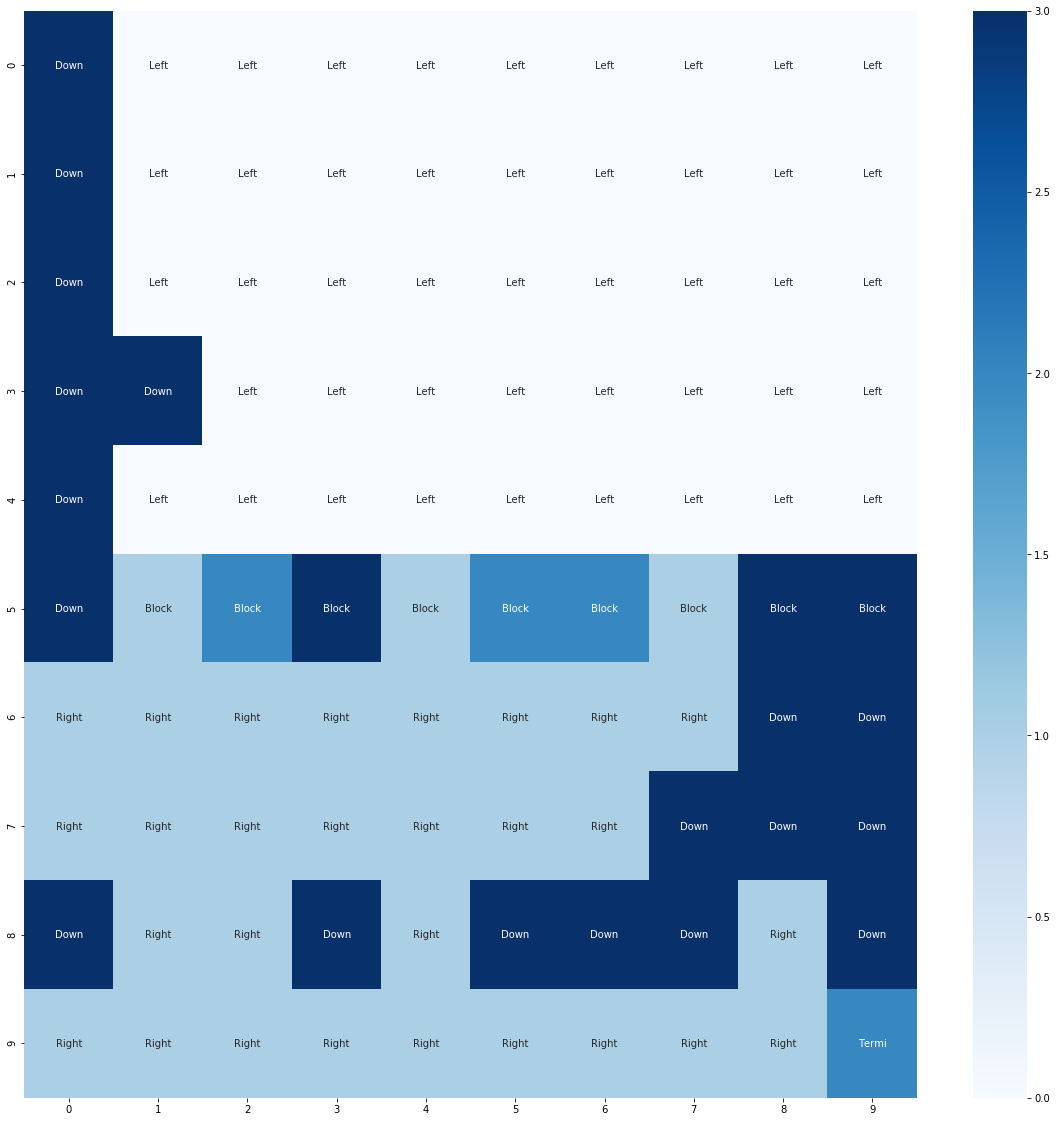

Average Length of Episode: 1297.7687861271677
Planning size: 3


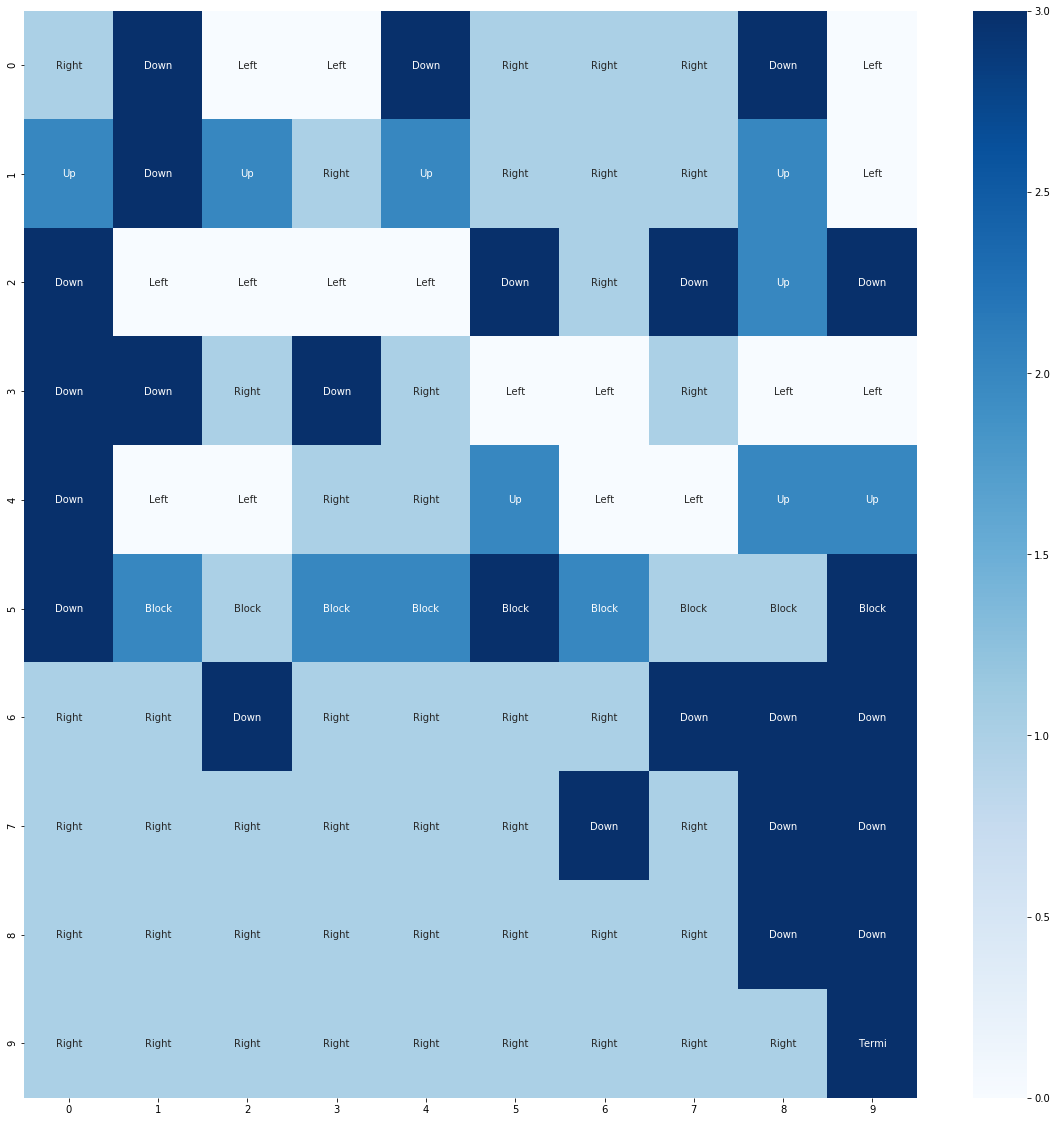

Average Length of Episode: 996.2692307692307
Planning size: 5


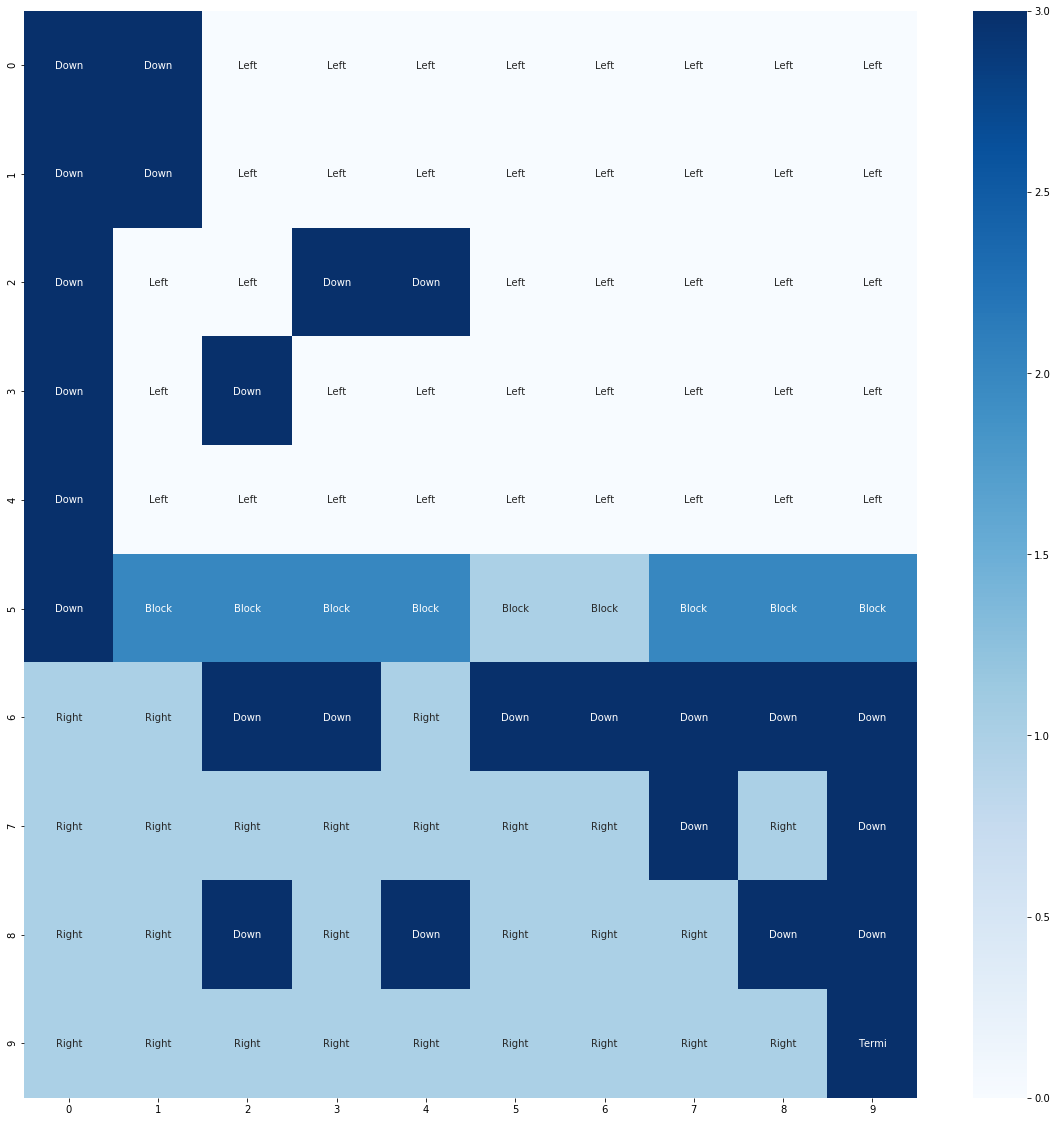

Average Length of Episode: 991.7826086956521


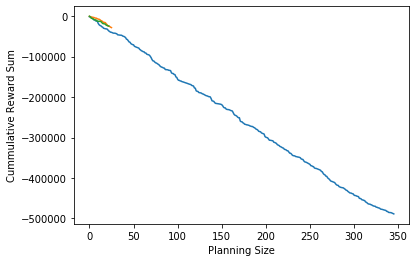

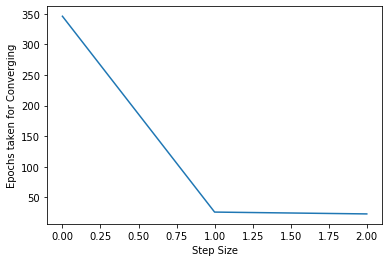

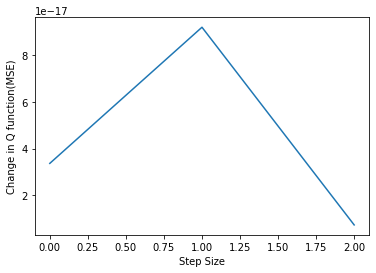

Epochs Count [346, 26, 23]
Difference(MSE) Value [3.369031325905964e-17, 9.175506328761679e-17, 7.448550585643646e-18]


In [4]:
blocks = [(5,i) for i in range(1,10)]

epochs_count = []
diff_count = []
cumm_rewards = []
for i in [0,3,5]:
    print("Planning size:", i)
    game = DynaMaze(10, i, (9,9), blocked_blocks = blocks, mode_type = 'DQ', verbose=False)
    diff, epochs, avg_episode_length, total_rewards = game.play(epochs=1000, threshold=1e-16, changed=False)
    print("Average Length of Episode:", avg_episode_length)
    epochs_count.append(epochs)
    diff_count.append(diff)
    cumm_rewards.append(np.cumsum(total_rewards))

plt.plot(cumm_rewards[0])
plt.plot(cumm_rewards[1])
plt.plot(cumm_rewards[2])
plt.xlabel('Planning Size')
plt.ylabel('Cummulative Reward Sum')
plt.show()
plt.plot(epochs_count)
plt.xlabel('Step Size')
plt.ylabel('Epochs taken for Converging')
plt.show()
plt.plot(diff_count)
plt.xlabel('Step Size')
plt.ylabel('Change in Q function(MSE)')
plt.show()

print('Epochs Count', epochs_count)
print('Difference(MSE) Value', diff_count)

# DQ+ Learning

Planning size: 0


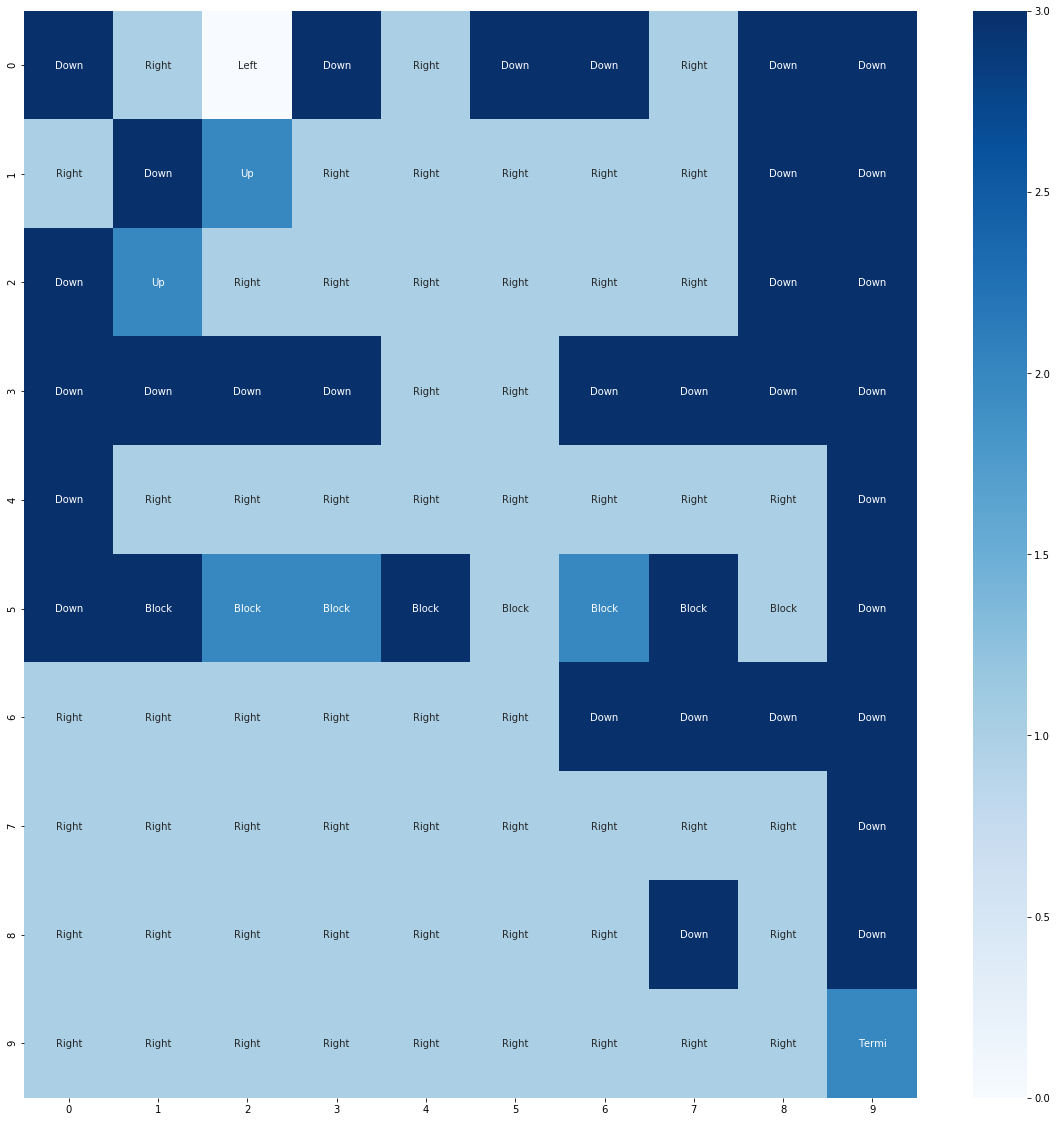

Average Length of Episode: 515.3217391304348
Planning size: 3


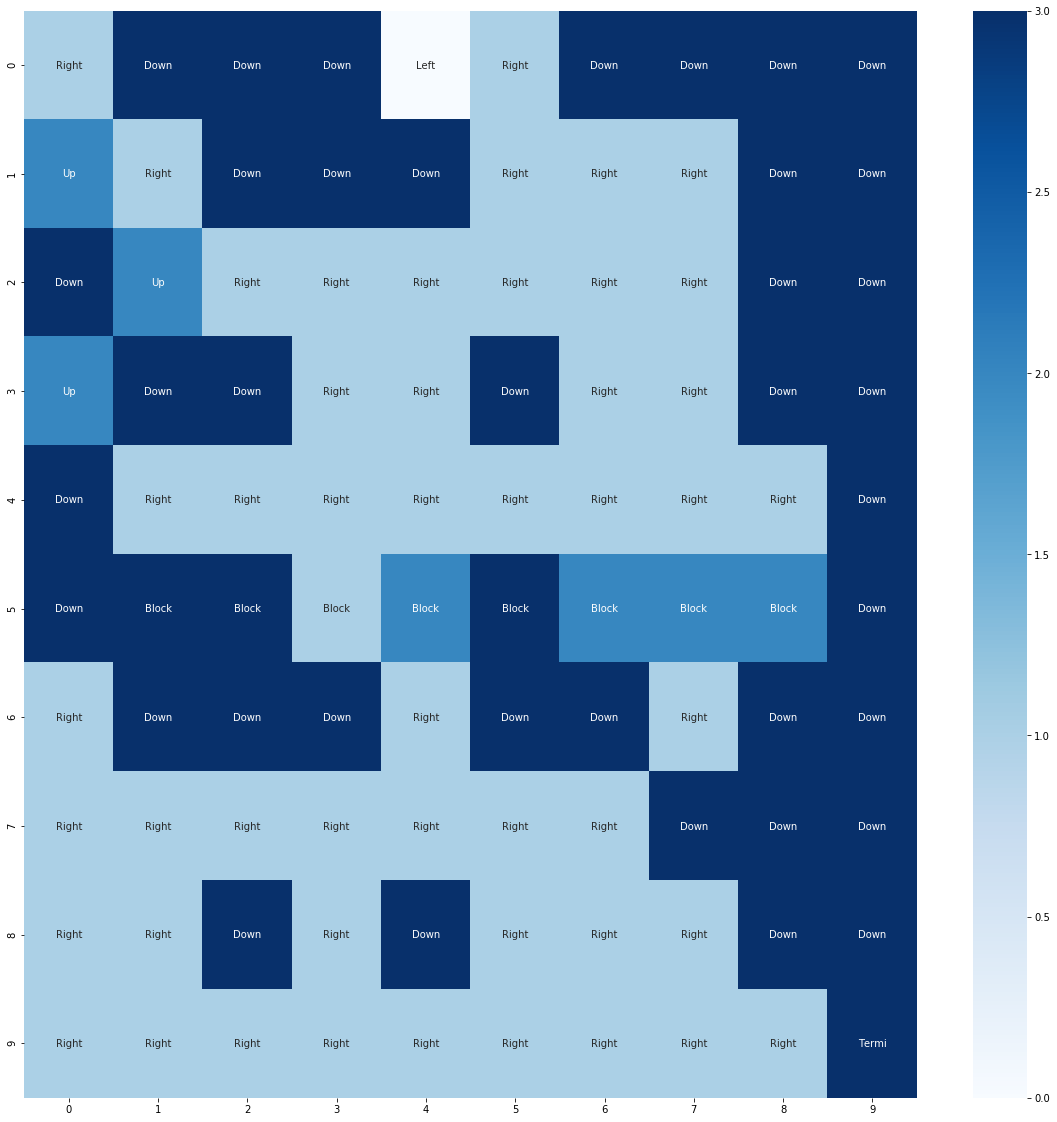

Average Length of Episode: 456.758064516129
Planning size: 5


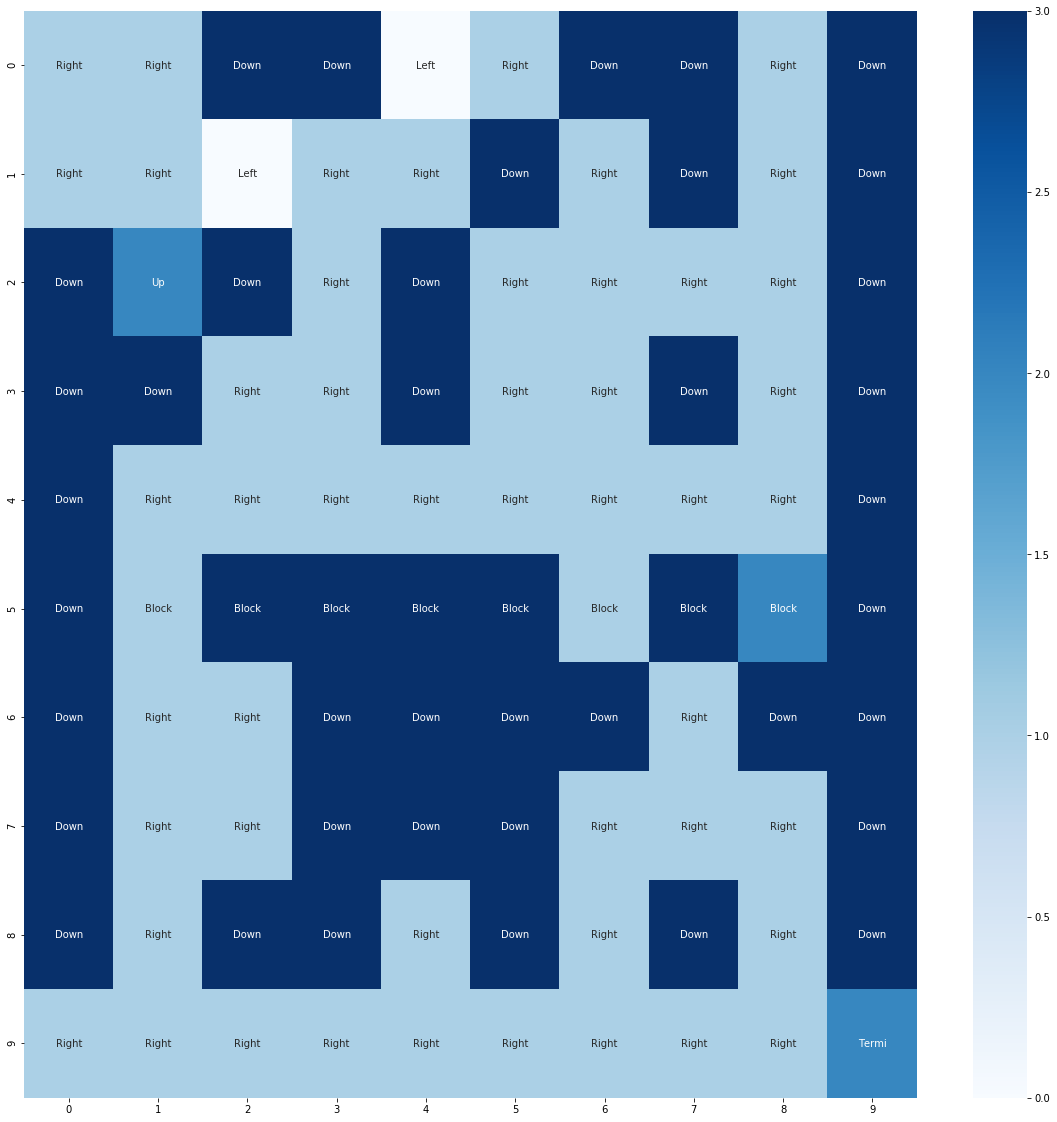

Average Length of Episode: 540.1860465116279


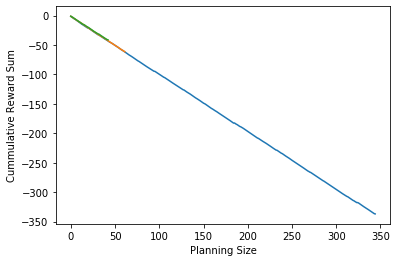

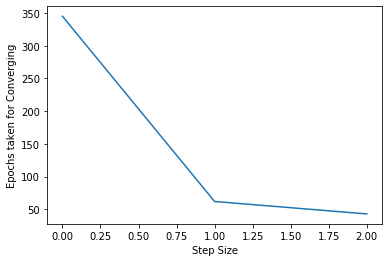

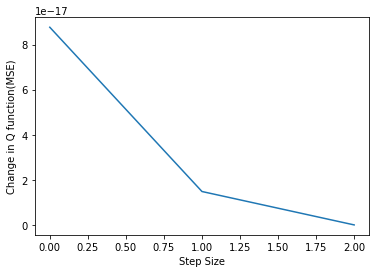

Epochs Count [345, 62, 43]
Difference(MSE) Value [8.767923411168145e-17, 1.4818105946541725e-17, 4.585236694257994e-25]


In [5]:
blocks = [(5,i) for i in range(1,10)]

epochs_count = []
diff_count = []
cumm_rewards = []
for i in [0,3,5]:
    print("Planning size:", i)
    game = DynaMaze(10, i, (9,9), blocked_blocks = blocks, mode_type = 'DQ+', verbose=False)
    diff, epochs, avg_episode_length, total_rewards = game.play(epochs=1000, threshold=1e-16)
    print("Average Length of Episode:", avg_episode_length)
    epochs_count.append(epochs)
    diff_count.append(diff)
    cumm_rewards.append(np.cumsum(total_rewards))

plt.plot(cumm_rewards[0])
plt.plot(cumm_rewards[1])
plt.plot(cumm_rewards[2])
plt.xlabel('Planning Size')
plt.ylabel('Cummulative Reward Sum')
plt.show()
plt.plot(epochs_count)
plt.xlabel('Step Size')
plt.ylabel('Epochs taken for Converging')
plt.show()
plt.plot(diff_count)
plt.xlabel('Step Size')
plt.ylabel('Change in Q function(MSE)')
plt.show()

print('Epochs Count', epochs_count)
print('Difference(MSE) Value', diff_count)

# DQ Learning with shortcut maze

Planning size: 0


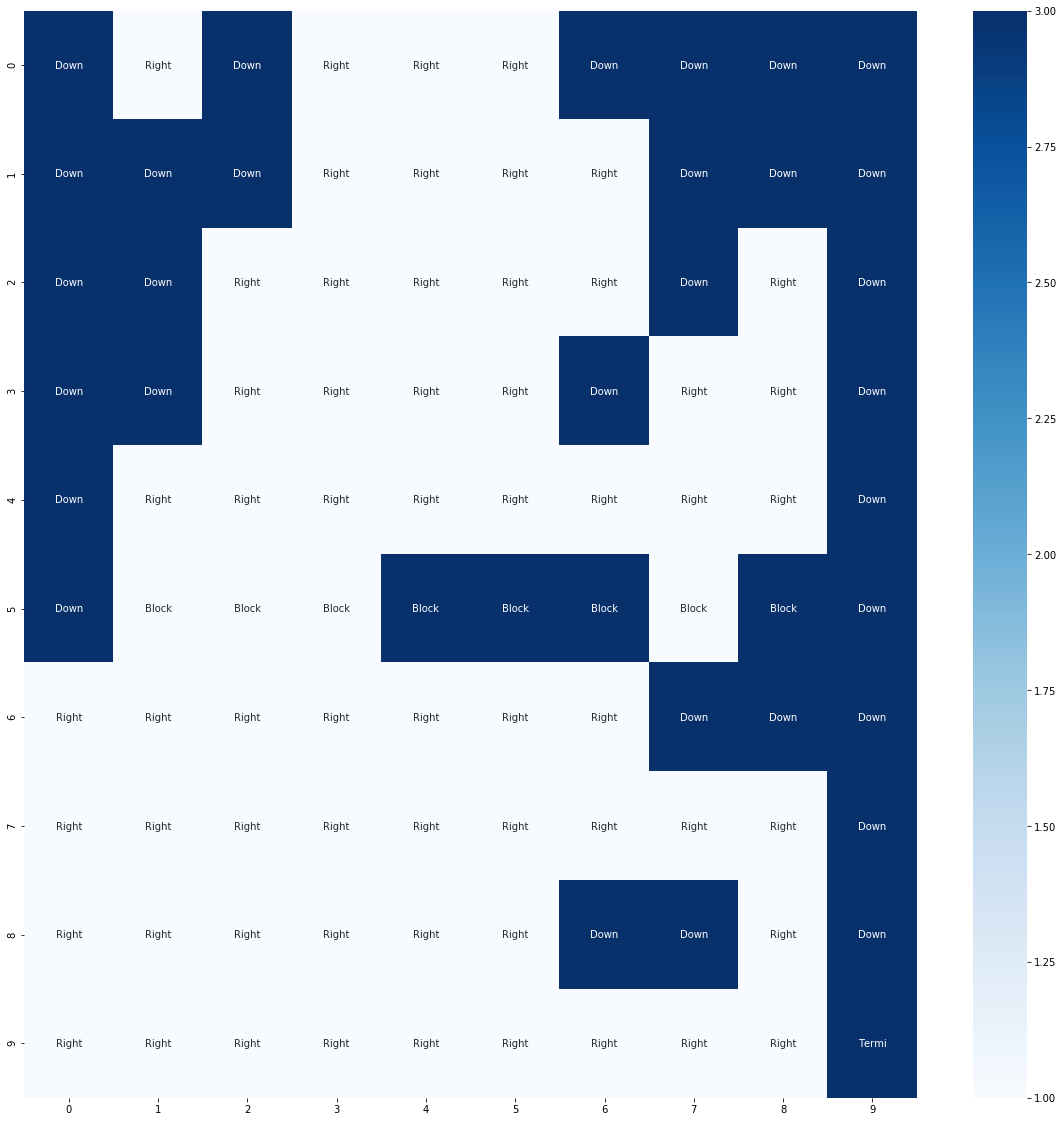

Average Length of Episode: 506.5190615835777
Planning size: 3


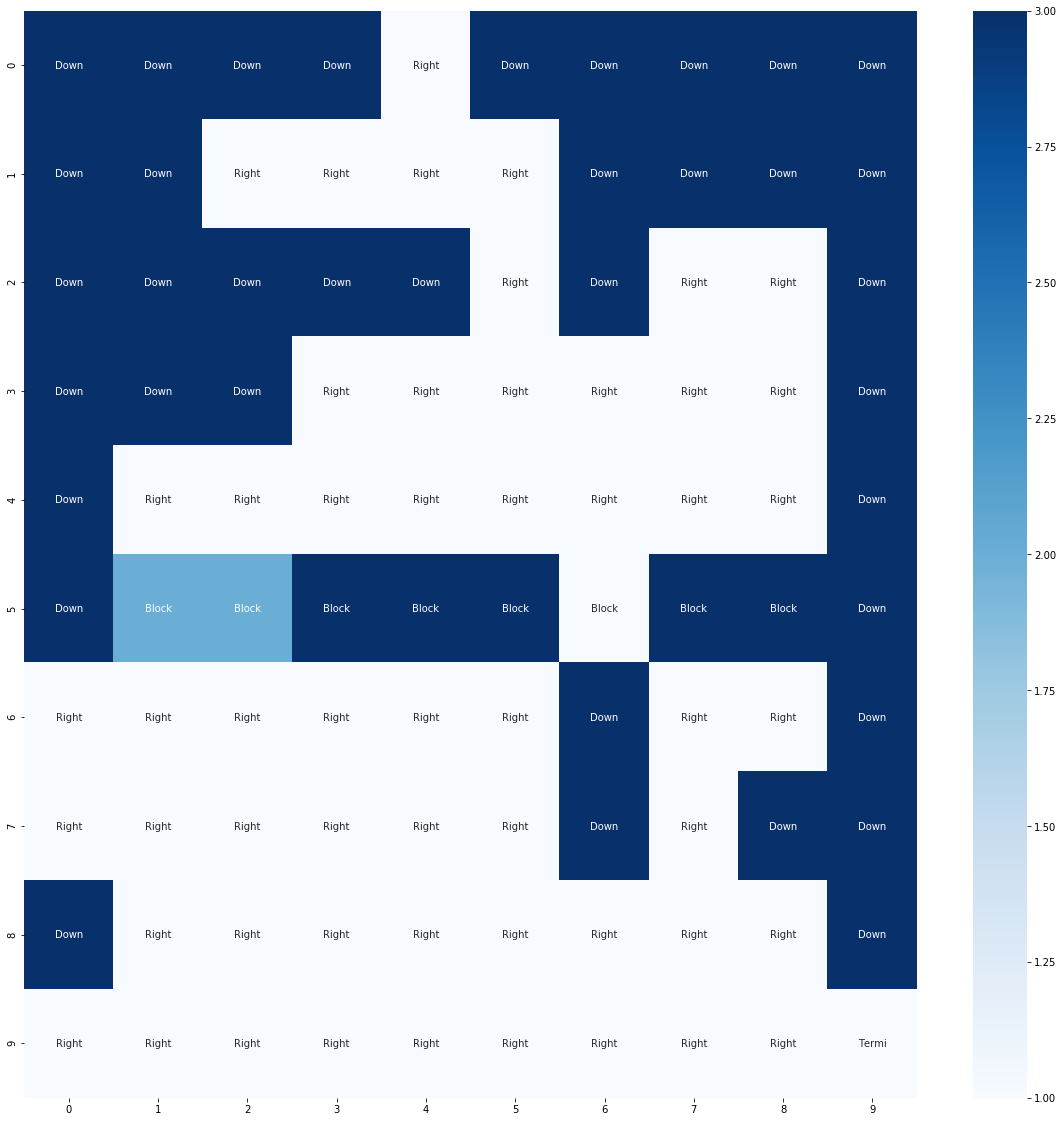

Average Length of Episode: 474.135593220339
Planning size: 5


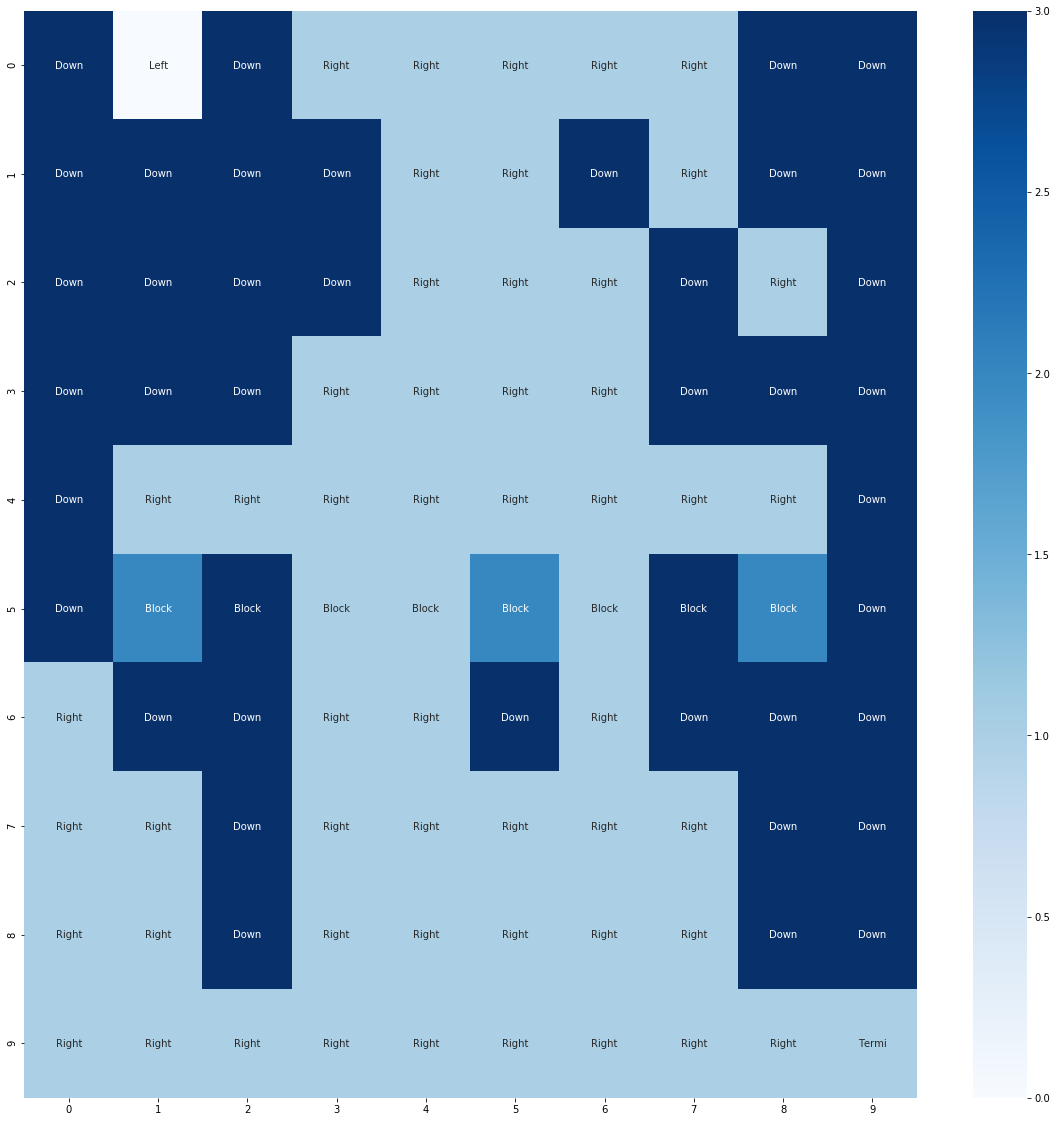

Average Length of Episode: 441.8958333333333


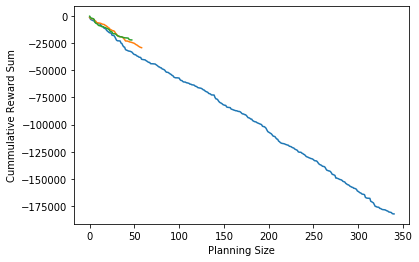

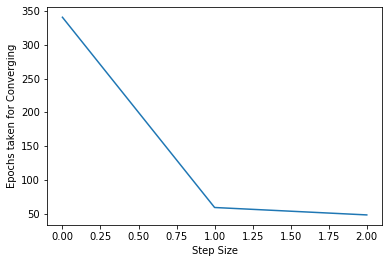

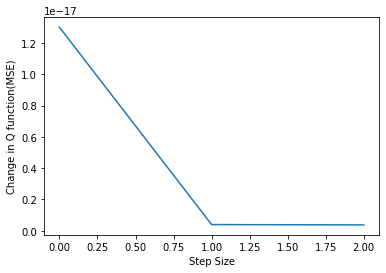

Epochs Count [341, 59, 48]
Difference(MSE) Value [1.3008049174946797e-17, 3.9767320257852284e-19, 3.754744876536313e-19]


In [6]:
blocks = [(5,i) for i in range(1,10)]

epochs_count = []
diff_count = []
cumm_rewards = []
for i in [0,3,5]:
    print("Planning size:", i)
    game = DynaMaze(10, i, (9,9), blocked_blocks = blocks, mode_type = 'DQ', verbose=False)
    diff, epochs, avg_episode_length, total_rewards = game.play(epochs=1000, threshold=1e-16, changed=True)
    print("Average Length of Episode:", avg_episode_length)
    epochs_count.append(epochs)
    diff_count.append(diff)
    cumm_rewards.append(np.cumsum(total_rewards))

plt.plot(cumm_rewards[0])
plt.plot(cumm_rewards[1])
plt.plot(cumm_rewards[2])
plt.xlabel('Planning Size')
plt.ylabel('Cummulative Reward Sum')
plt.show()
plt.plot(epochs_count)
plt.xlabel('Step Size')
plt.ylabel('Epochs taken for Converging')
plt.show()
plt.plot(diff_count)
plt.xlabel('Step Size')
plt.ylabel('Change in Q function(MSE)')
plt.show()

print('Epochs Count', epochs_count)
print('Difference(MSE) Value', diff_count)

### Deductions/Observations

<ul>
    <li>DQ Learning: The larger the planning steps lesser the epochs are required for the convergence.</li>
    <li>DQ+ Learning: The larger the planning steps lesser the epochs are required for the convergence.</li>
    <li>DQ Learning: The number of epochs in shortcut maze is greater than the blocking maze</li>
</ul>